In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots
using ArnoldiMethod, LinearAlgebra, LinearMaps

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 2
selected_ev            = 3;      # which Eigenvector to choose
ϵ                      = 0.5     # perturbation
a                      = 0.98;   # parameter value corresponding to ϵ=0

In [4]:
T(x,p) = [rem2pi(x[1] + x[2] + (a+p)*sin(x[1]), RoundDown),
               rem2pi(       x[2] + (a+p)*sin(x[1]), RoundDown)]

T (generic function with 1 method)

In [5]:
LL, UR = (0.0, 0.0), (2π, 2π)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order)
pred(x,y) = peuclidean(x, y, [2π, 2π]) < 1e-9
bdata = BoundaryData(ctx, pred);

In [6]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [7]:
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

  2.627666 seconds (13.17 M allocations: 561.467 MiB, 4.57% gc time)


In [8]:
#from the ArnoldiMethod.jl documentation
struct ShiftAndInvert{TA,TB,TT}
    A_lu::TA
    B::TB
    temp::TT
end

function (M::ShiftAndInvert)(y,x)
    mul!(M.temp, M.B, x)
    ldiv!(y, M.A_lu, M.temp)
end

function construct_linear_map(A,B)
    a = ShiftAndInvert(lu(A),B,Vector{eltype(A)}(undef, size(A,1)))
    LinearMap{eltype(A)}(a, size(A,1), ismutating=true)
end

construct_linear_map (generic function with 1 method)

  3.360898 seconds (9.41 M allocations: 546.093 MiB, 5.23% gc time)


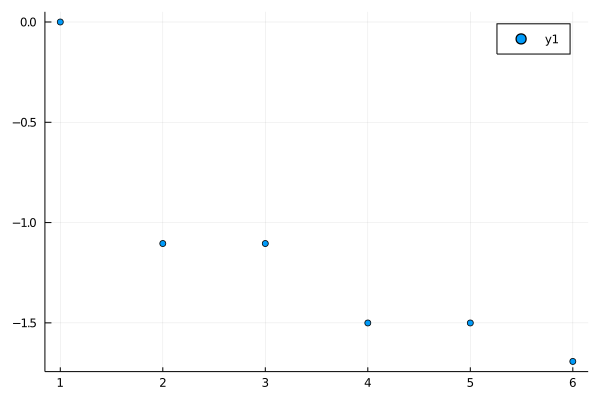

In [9]:
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
Plots.scatter(1:length(λ₀),λ₀,fmt=:png)

In [10]:
u₀ = u₀[:,selected_ev] ./ sqrt(u₀[:,selected_ev]'*M*u₀[:,selected_ev])        # L2 normalization
u₀ = u₀*sign(sum(u₀))
λ₀ = λ₀[selected_ev]

-1.1044208499270591

In [11]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

  2.731045 seconds (16.82 M allocations: 820.883 MiB, 7.53% gc time)


In [12]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.706932 seconds (2.40 M allocations: 138.853 MiB, 4.01% gc time)


-0.2243414703098269

In [13]:
# calculate the exact uϵ
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
uϵ = uϵ*sign(sum(uϵ))
λϵ

-1.2508057160124293

In [14]:
λ₀ + ϵ*λ_dot

-1.2165915850819726

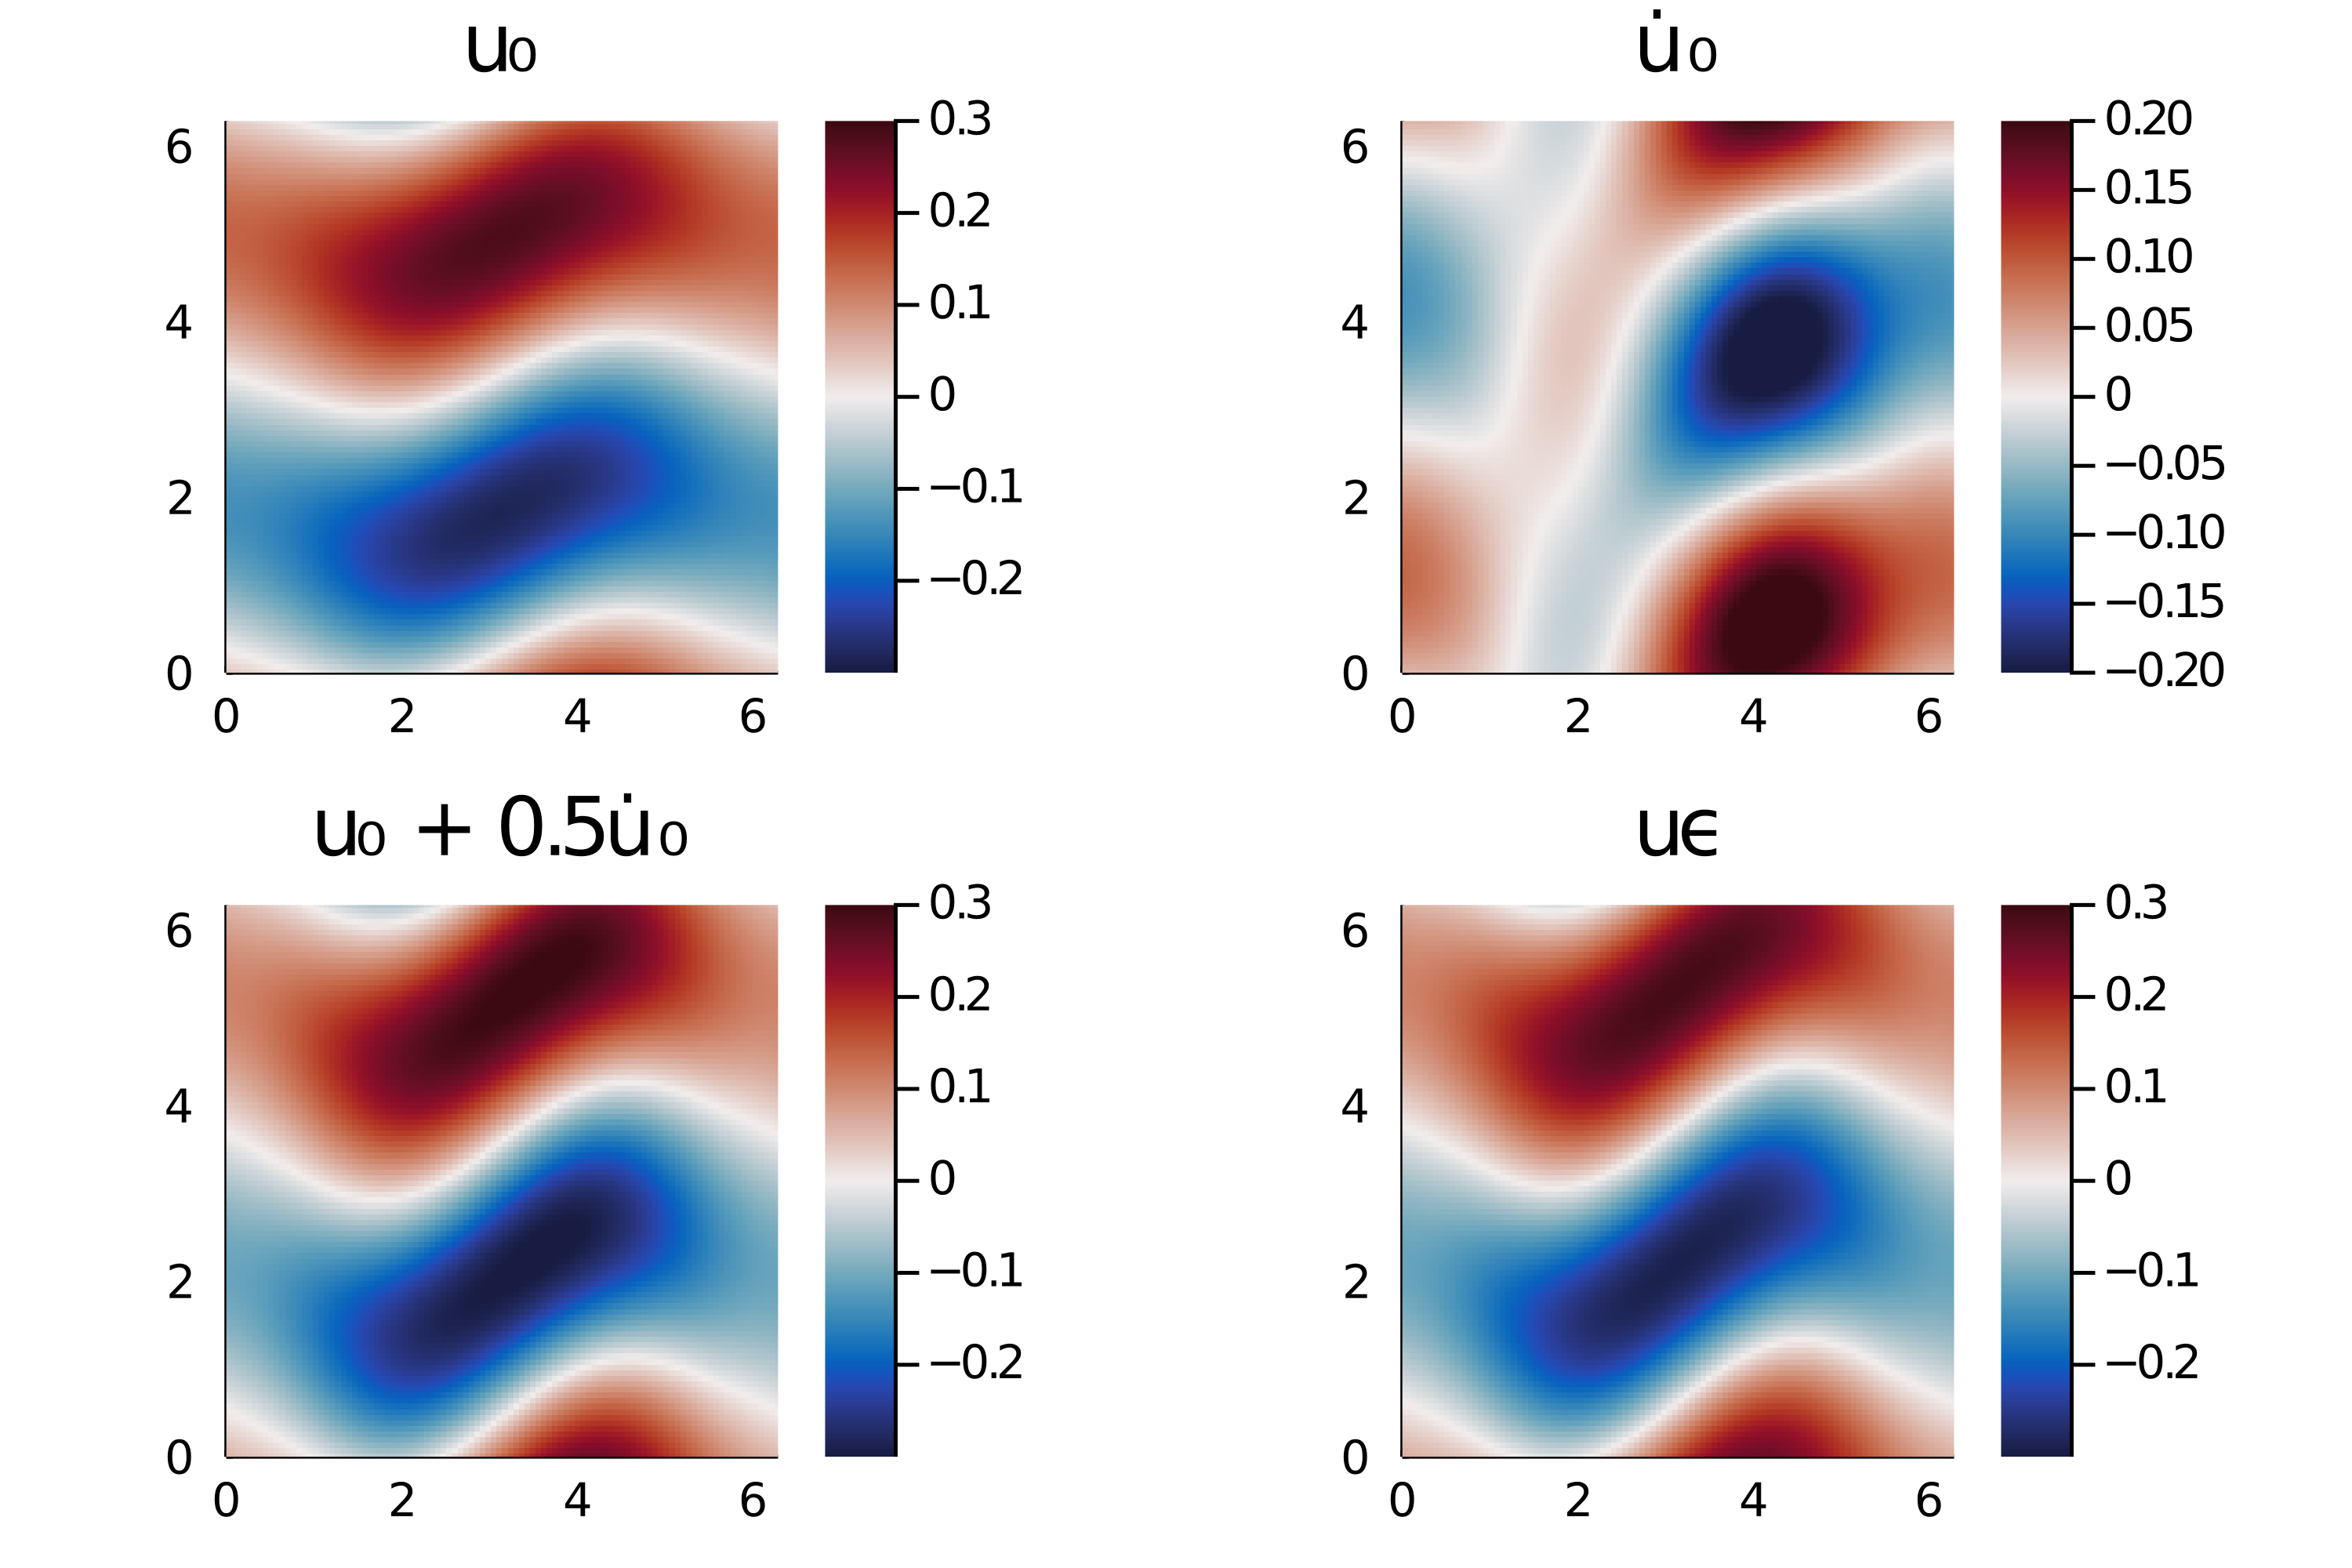

In [25]:
color =    :balance
xticks =   0:2:6
yticks =   0:2:6
colorbar = :left
cmin =     -0.3
cmax =     0.3
cmin_lr =  -0.2
cmax_lr =  0.2
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [16]:
using Contour
using StaticArrays

In [17]:
#Contour.jl needs StaticArrays
T_static(x) = SVector{2,Float64}(T(x,0))

T_static (generic function with 1 method)

In [18]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,T_static,tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,T_static,tolerance=1e-10)
end

best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0002845265423623844
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.000854058908262123
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0014235912741618062
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.001993123640061545
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.002562656005961228
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0031321883718609667
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.00370172073776065
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0042712531036603885
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.004840785469560072
└ @ Main In[18]:15
┌ Warning: Curre

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05325103657103547
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05382056893693521
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05439010130283489
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05495963366873463
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.055529166034634314
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05609869840053405
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.056668230766433736
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.057237763132333475
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05780729549823316
└ @ Main In[18]:15
┌ Warning: Currently only

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10564801423380887
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10621754659970861
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.1067870789656083
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10735661133150803
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10792614369740772
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10849567606330746
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10906520842920714
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10963474079510688
└ @ Main In[18]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.11020427316100656
└ @ Main In[18]:15
┌ Warning: Currently only con

Dynamic Cheeger value:	1.6036996225576745
Levelset:		0.1813958188984704


cheeger value		length			length transported	volume
2.757479935348776	12.285307132739739	36.5195048847195	9.112839101459207
1.6036996225576745	10.383984684293493	9.271485088934565	6.128164369671783


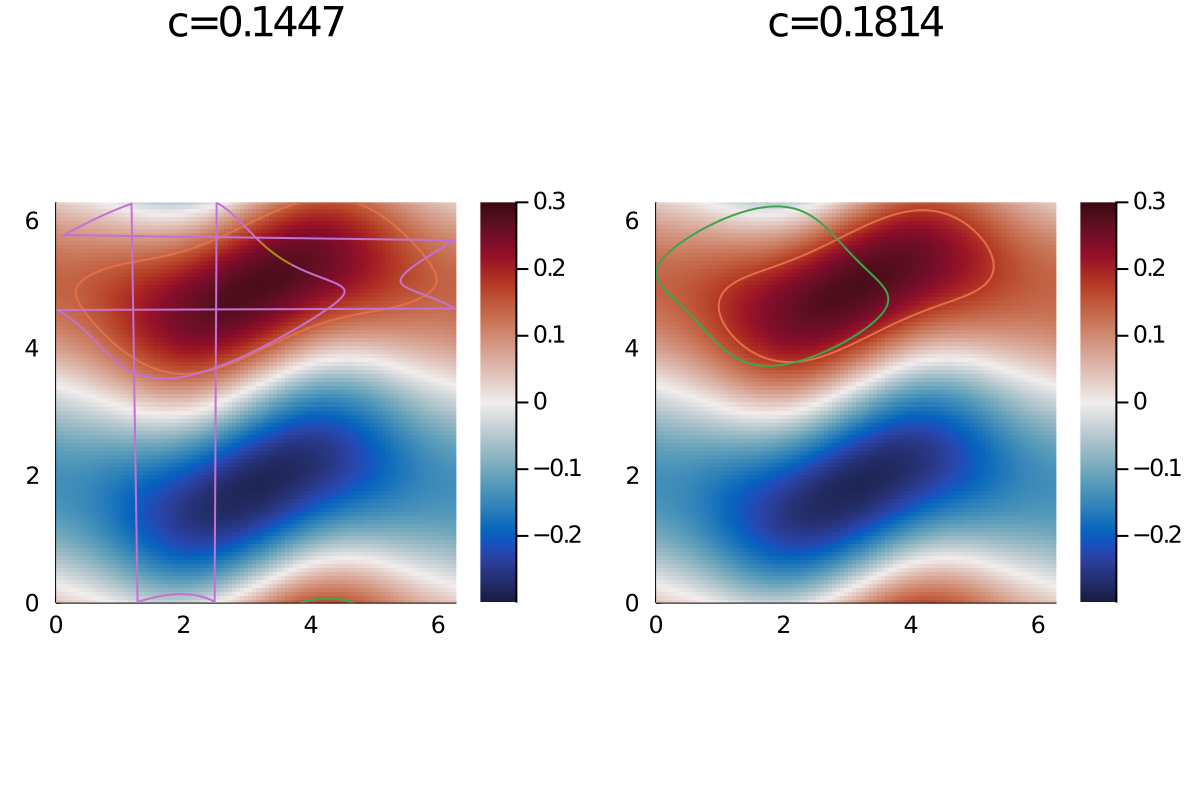

In [19]:
# value from paper
c_paper = 0.1447
plot_paper = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_paper,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀, c_paper, bdata=bdata))
curves_moved = [Main.CoherentStructures.apply2curve(T_static,c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], T_static)
print("cheeger value\t\tlength\t\t\tlength transported\tvolume\n")
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end

# our value
c_ours = level(best_levelset)
plot_ours = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_ours,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀, c_ours, bdata=bdata))
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(T_static,c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end

Plots.plot(plot_paper,plot_ours,fmt=:png,dpi=200)

In [20]:
using PyCall
using PyPlot
@pyimport matplotlib.pyplot as plt

ErrorException: [91m@pyimport: plt already defined[39m

In [21]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

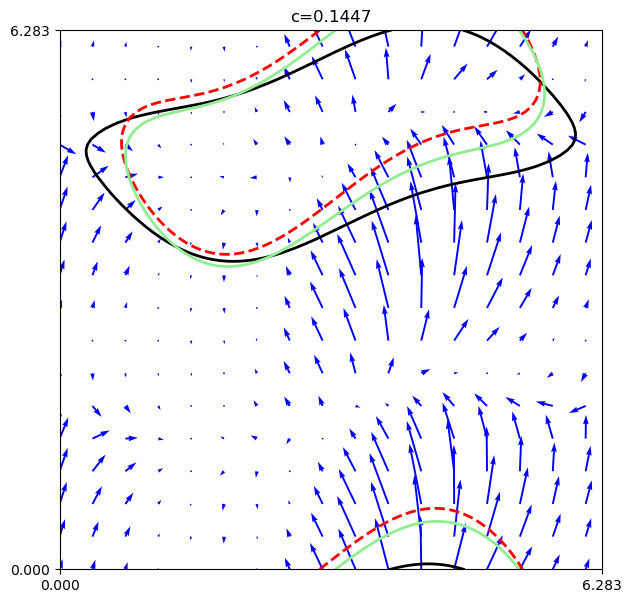

In [22]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0,2π), ylim=(0,2π), xticks=(0,2π), yticks=(0,2π))
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot,bdata=bdata)...,ax,scale=2,step=6)
curves           = lines(get_levelset(ctx, u₀, c_paper,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ, c_paper,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_paper,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_paper,digits=4))");

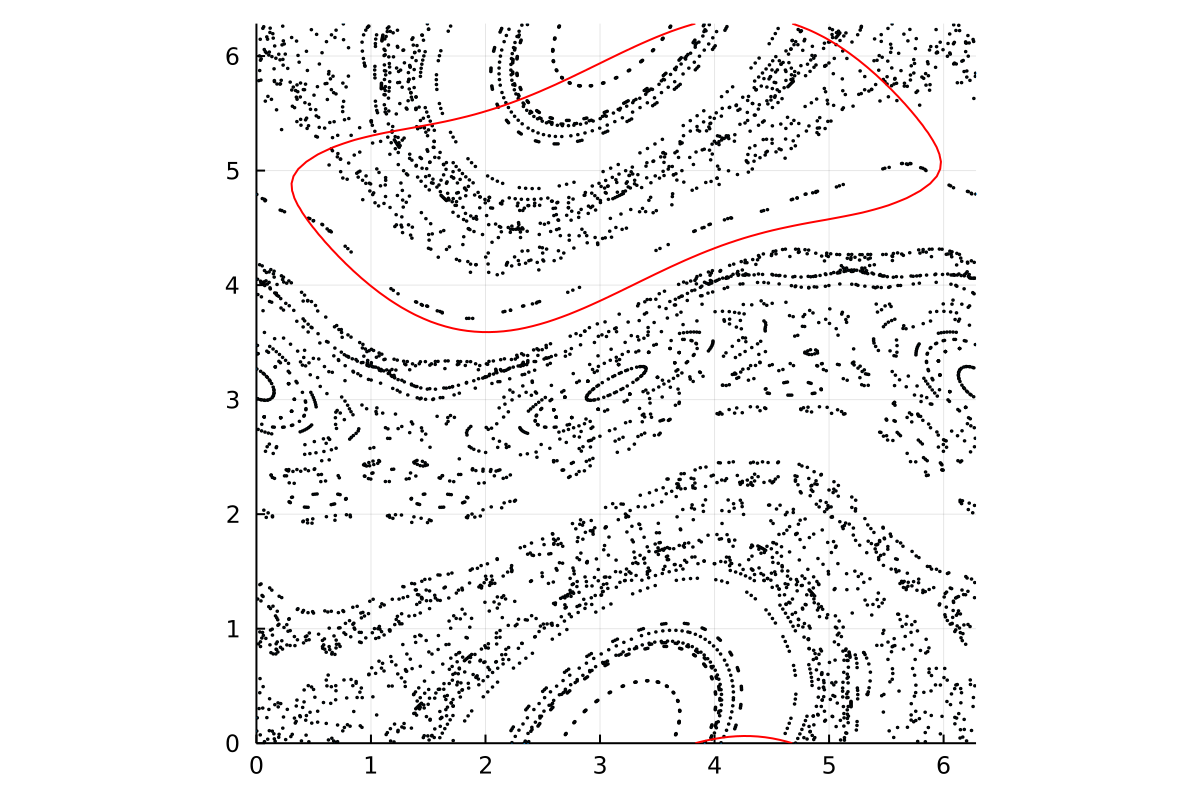

In [23]:
using Random


X = Tuple{Float64,Float64}[]
for i in 1:50
    Random.seed!(i)
    x = 2π .* (rand(), rand())
    for i in 1:100
        x = T(x,0)
        push!(X,(x[1],x[2]))
    end
end

Plots.scatter(X, markersize=1)
for c in curves
    xs, ys = coordinates(c)
    plot!(xs, ys,color=:red)
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,2π),ylims=(0,2π))